**Redes Neurais Profundas | Transferência de Estilo entre imagens - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Download das imagens
* Pré-processamento das imagens
* Contrução do modelo
* Extração das *features*
  * *Features* de estilo
  * *Features* de conteúdo
* Construção da função *loss*
  * *Loss* de estilo
  * *Loss* de conteúdo
* Sintetizando a nova imagem
* Execução do modelo
* Regularização com *Total Variation*

---


#1. Download das imagens

Vamos iniciar baixando um par de imagens da web. Você pode escolher novas imagens para **conteúdo** e **estilo** indicando quaisquer outras URLs no comando a seguir:


In [ ]:
!wget -q -O conteudo.jpg https://rollingstone.uol.com.br/media/_versions/elenco_de_the_office_foto_divulgacao_nbc_widelg.jpg
!wget =q -O estilo.jpg https://a-static.mlcdn.com.br/1500x1500/o-baile-em-moulin-de-la-galette-pierre-auguste-renoir-30x40-tela-canvas-para-quadro-santhatela/santhatela2/13704213590/abaff41d07ea1cbc167be909c6df7130.jpg

--2022-07-08 13:59:25--  http://=q/
Resolving =q (=q)... failed: Name or service not known.
wget: unable to resolve host address ‘=q’
--2022-07-08 13:59:25--  https://a-static.mlcdn.com.br/1500x1500/o-baile-em-moulin-de-la-galette-pierre-auguste-renoir-30x40-tela-canvas-para-quadro-santhatela/santhatela2/13704213590/abaff41d07ea1cbc167be909c6df7130.jpg
Resolving a-static.mlcdn.com.br (a-static.mlcdn.com.br)... 179.191.190.70, 179.191.190.64, 179.191.190.66, ...
Connecting to a-static.mlcdn.com.br (a-static.mlcdn.com.br)|179.191.190.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179939 (176K) [image/jpeg]
Saving to: ‘estilo.jpg’

estilo.jpg          100%[===================>] 175.72K  --.-KB/s    in 0.04s   

2022-07-08 13:59:26 (4.47 MB/s) - ‘estilo.jpg’ saved [179939/179939]

FINISHED --2022-07-08 13:59:26--
Total wall clock time: 0.3s
Downloaded: 1 files, 176K in 0.04s (4.47 MB/s)


Vamos em seguida apenas visualizar as imagens baixadas para ter certeza que elas estão ok:

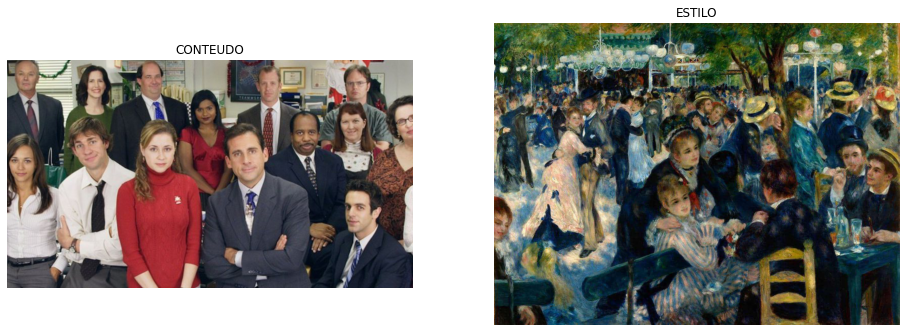

In [ ]:
from matplotlib import pyplot as plt
import imageio
import numpy as np

content_image = imageio.imread('conteudo.jpg')
style_image = imageio.imread('estilo.jpg')


fig = plt.gcf()
fig.set_size_inches(16, 8)

sp = plt.subplot(1, 2, 1)
sp.axis('Off')
sp.set_title("CONTEUDO")
plt.imshow(content_image)

sp = plt.subplot(1, 2, 2)
sp.axis('Off')
sp.set_title("ESTILO")
plt.imshow(style_image)
plt.show()


#2. Pré-processamento das images

Se faz necessário transformar as imagens em tensores $4d$ (primeira dimensão para o batch). Por fim, imprimimos as dimensões dos tensores que guardam as imagens de conteúdo e de estilo.

In [ ]:
import tensorflow as tf

def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image

In [ ]:
content_image, style_image = load_images('conteudo.jpg', 'estilo.jpg')
print("dimensao do tensor conteudo: ", content_image.shape)
print("dimensao do tensor estilo: ", style_image.shape)

dimensao do tensor conteudo:  (1, 288, 512, 3)
dimensao do tensor estilo:  (1, 380, 512, 3)


#3. Construção do modelo

Nesse exemplo, nosso modelo será inteiramente baseado nos layers intermediários da VGG-19 cuja arquitetura pode ser visualizada a seguir:

In [ ]:
from keras import backend as K
import tensorflow as tf
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

574726144/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

A seguir, visualizamos os layers que irão compor as representações de estilo e conteúdo de acordo com os diagramas que seguem:

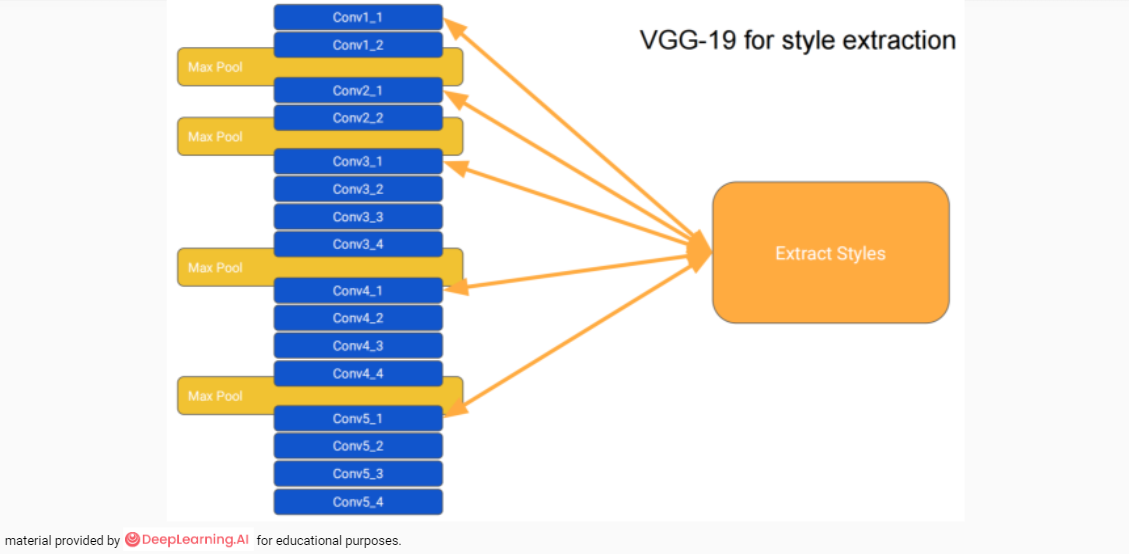

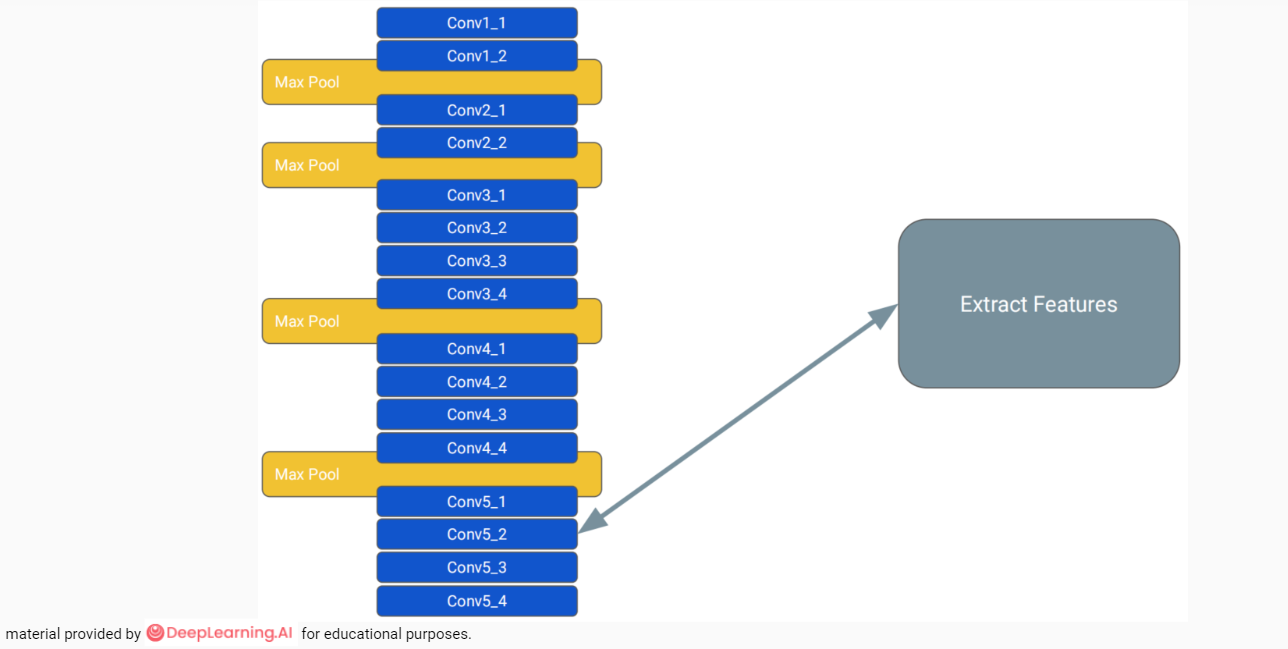

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

Criamos então um modelo auxiliar que compartilha a mesma entrada da VGG-19, porém cujas saídas são aquelas selecionadas nas listas $style\_layers$ e $content\_layers$:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

Por fim, segue a descrição desse novo modelo:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#4. Extração das *features*

Nessa etapa codificamos as features que serão utilizadas nas losses de **conteúdo** e de **estilo**.

##4.1. Extração das *features* de estilo

Primeiramente, codificamos $G(\cdot)_{i,j}^{(l)}$ que será utilizado no cálculo da loss de estilo:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image

def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  
  preprocessed_style_image = preprocess_image(image) 
  #print(preprocessed_style_image.shape)
  #print(type(preprocessed_style_image))
  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

##3.2. Extração das *features* de conteúdo

Em seguida, codificamos $VGG(\cdot)_{i,j}$ que será utilizado no cálculo da loss de conteúdo.

In [ ]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image) 

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

#5. Construção da loss

Codificaremos agora as *losses* que compõem a solução: $\ell_{total}(\mathbf{C}, \mathbf{S}, \mathbf{x})$, $\ell_{content}(\mathbf{C},\mathbf{x})$, e $\ell_{style}(\mathbf{S}, \mathbf{x})$. 

##5.1. *Loss* de estilo

O código que segue implementa $\ell_{style}(\mathbf{S}, \mathbf{x}) = \frac{1}{IJ} \sum_{i,j} (G(\mathbf{x})_{i,j}^{(l)}-G(\mathbf{C})_{i,j}^{(l)})^2$:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

##5.2. *Loss* de conteúdo

O código que segue implementa $\ell_{content}(\mathbf{S}, \mathbf{x}) = \frac{1}{2IJ} \sum_{i,j} (VGG(\mathbf{x})_{i,j}^{(l)}-VGG(\mathbf{S})_{i,j}^{(l)})^2$:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

##5.3. *Loss* final

O código que implementa $\ell_{total}(\mathbf{C},\mathbf{S},\mathbf{x}) = \alpha\ell_{content}(\mathbf{C},\mathbf{x})+\beta\ell_{style}(\mathbf{S},\mathbf{x})$:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
    
  # sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  return total_loss

#6. Sintetizando a nova imagem

O bloco de código a seguir implementa o esquema de sintetização descrito na imagem que segue:



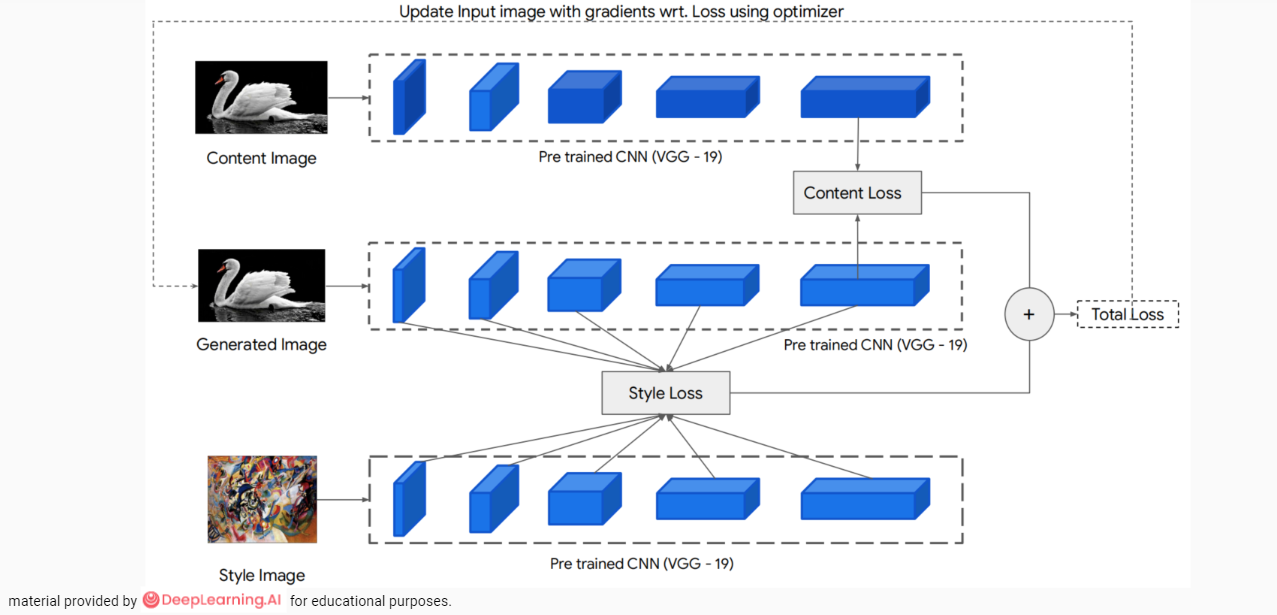

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

  # calculate gradients of loss with respect to the image
  #print(f'loss {type(loss)}')
  #print(f'image {type(image)}')
  gradients = tape.gradient(loss, image) 
  #print(f'gradientes {gradients}')

  return gradients

def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

def update_image_with_style(image, style_targets, content_targets, style_weight, 
                          var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

Por fim, a função *fit_style_transfer* orquestra todas as chamadas:

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
from IPython.display import clear_output
from IPython.display import display as display_fn

def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

#7. Execução do modelo

A seguir, podemos escolher os hyperparâmetros de execcução e iniciar o treinamento:

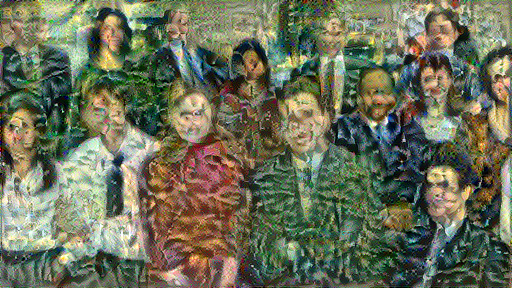

Train step: 200
.................................................................

In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
# define style and content weight
style_weight =  2e-2
content_weight = 6e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)

#8. Regularização com Total Variation

O resultado anterior mostra um excesso de componentes alta frequência na solução. Para resolver essa questão, adicionamos um termo regularizador baseado no Total Variation da imagem gerada ao longo das atualizações realizadas pela função *update_image_with_style*: 

In [ ]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight, TV_regularization=False):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  total_variation_weight = 1
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 
    if TV_regularization == True:
      loss = loss + total_variation_weight * tf.image.total_variation(image)

  # calculate gradients of loss with respect to the image
  #print(f'loss {type(loss)}')
  #print(f'image {type(image)}')
  gradients = tape.gradient(loss, image) 
  #print(f'gradientes {gradients}')

  return gradients

In [ ]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                          var_weight, content_weight, optimizer, TV_regularization=False):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight, TV_regularization) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [ ]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1, TV_regularization=False):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer, TV_regularization) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

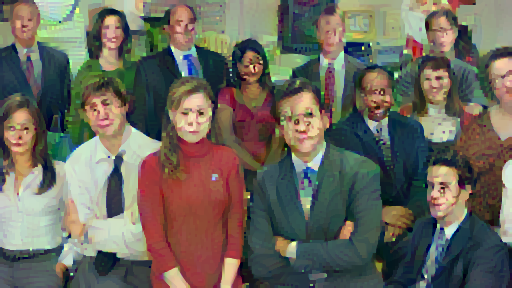

Train step: 1000


In [ ]:
#codigo sugerido pelo DeepLearning.AI para fins educacionais.
# define style and content weight
style_weight =  2e-2
content_weight = 6e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=50, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100, TV_regularization=True)